In [1]:
# !pip3 install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

# !pip3 install rich numpy matplotlib

# !pip3 install nms scikit-image

# !pip3 install jupyter-tensorboard

# !pip3 install "opencv-python-headless<4.3"

# !pip install ipywidgets
# !pip install nms

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.patches as patches
sys.path.append("..")

from Models.splinedist import *
import pytorch_lightning as pl
import torch
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor, RichProgressBar, RichModelSummary
from Datasets.DSB18 import * 

In [3]:

logger = pl_loggers.TensorBoardLogger(
    save_dir=os.path.join(os.getcwd(), "pl_logs"),
    name="spline_dist",
    log_graph=True,
    default_hp_metric=True)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="Models/weights",
    filename="splineDist-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
)

earlystoping_callback = EarlyStopping("val_loss")

lr_logger = LearningRateMonitor(logging_interval="step")
summary = RichModelSummary(max_depth=-1)
progressbar = RichProgressBar()

callbacks = [checkpoint_callback] 


In [4]:
model = SplineDist(lambda1=0.9, lambda2=1e-4, learning_rate=3e-4, num_control_points=8, object_threshold=0.3, nms_threshold=0.01)

/users/Etu3/3801613/.local/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
data = Nuclie_datamodule(path=os.path.join(os.getcwd(), "..", "Datasets", "DSB18", "train"))
batch_x, batch_y = next(iter(data.val_dataloader()))
# showBatch((batch_x, batch_y))
# data = Nuclie_data(os.path.join(os.getcwd(), "src", "Datasets", "DSB18", "train"))
# for(img, target) in data:
#     print(img.shape)
#     # plt.imshow(img[0])
    

In [6]:
# from torchvision import io 
# for mask in os.listdir("C:\\SplineDist\\src\Datasets\\DSB18\\train\\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552\\masks/"):
#     io.read_image(mask)

In [ ]:
torch.cuda.empty_cache()
trainer = pl.Trainer(max_epochs=400,
                     gpus=[2],
                     callbacks=callbacks,
                     logger=logger,
                     num_sanity_val_steps=0)
trainer.fit(model, data)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/users/Etu3/3801613/.local/lib/python3.7/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):
../Models/unet.py:62: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
../Models/unet.py:63: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds tow

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/users/Etu3/3801613/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/users/Etu3/3801613/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [7]:
# # # torch.onnx.export(model, torch.rand(1, 3, 256, 256), "src/Models/onnx/splineDist.onnx",  opset_version=11)
model = model.to("cuda:2")
objectProbas, angles, distances, controlPoints = model(batch_x.to("cuda:2"))

In [8]:
# angles.max()
contours = getContourSamples(controlPoints, model.B3M).permute(1, 2, 3, 0, 4)
contours = contours.flatten(1, 2)#reshape(-1, MAX_CONTOUR_SIZE, 2)
(targetObjectProbas, targetOverlapProbas, targetContours) = batch_y

In [9]:
%timeit computeContourLoss(objectProbas, contours, targetObjectProbas, targetContours, shifts=model.shifts)
# # t = ((controlPoints.permute(0, 3, 4, 1, 2) -  model.shifts)*30+model.shifts).permute(0, 3)
# # t.min(), t.max()
# for i in range(8):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
#     ax1.imshow(distances[0, i].detach().cpu().numpy())
#     ax2.imshow(angles[0, i].detach().cpu().numpy())
#     plt.show()

../Models/splinedist.py:432: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  i, j = m//291, m%291


1.56 s ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit computeContourLoss(objectProbas, contours, targetObjectProbas, targetContours, shifts=model.shifts)
# ct = controlPoints[0].detach().cpu().numpy()
# fig = plt.figure(figsize=(10, 10))
# ax = fig.gca()
# plt.imshow(np.zeros((256, 256)), cmap="gray")
# for i in range(0, 256, 8):
#     for j in range(0, 256, 8):
#         ax.fill(ct[i, j, :, 0], ct[i, j, :, 1], 'o-')
# plt.show()


12.4 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


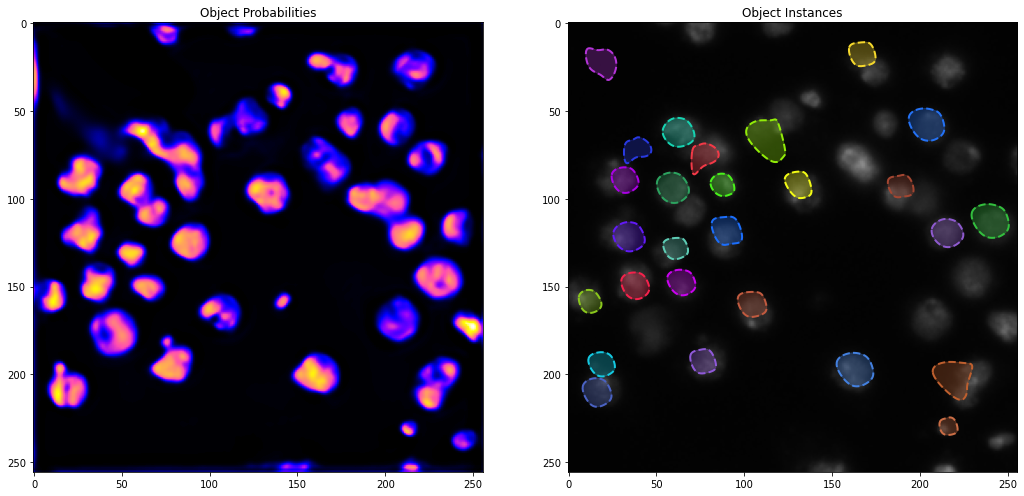

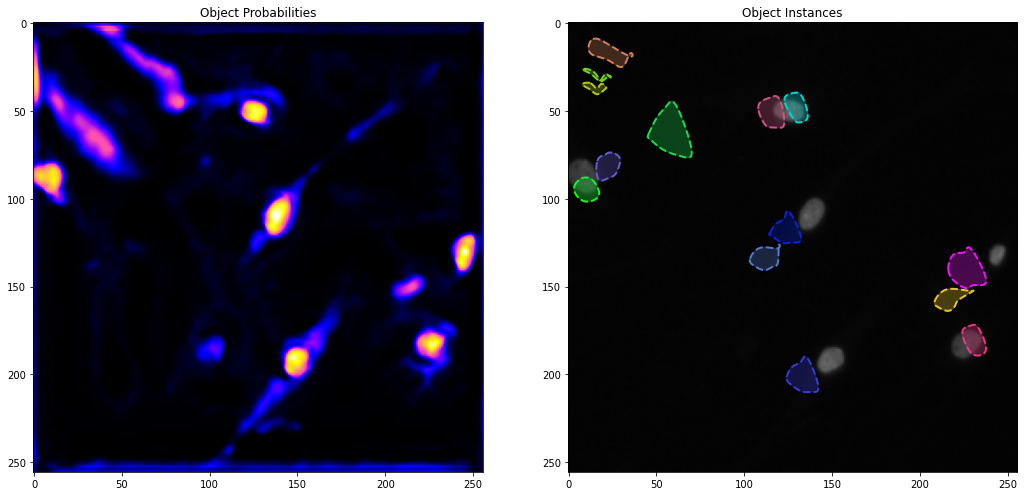

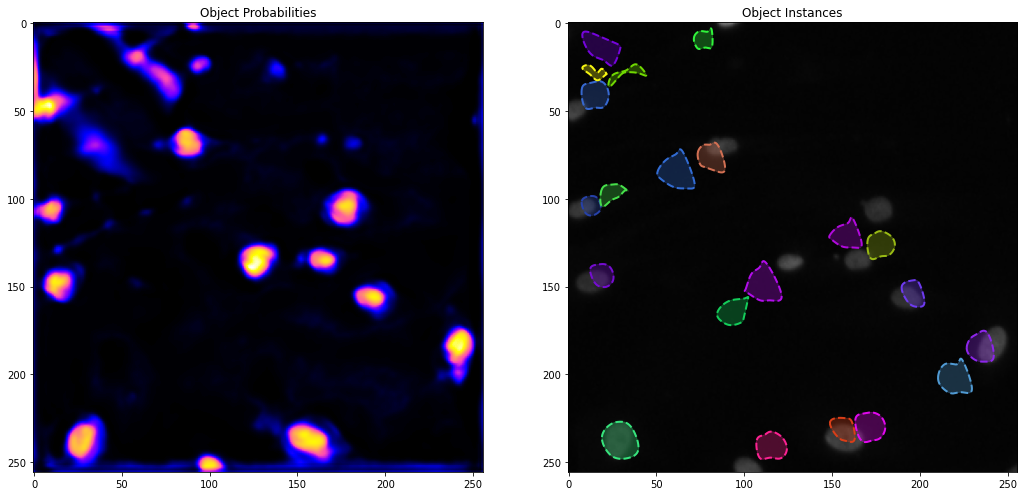

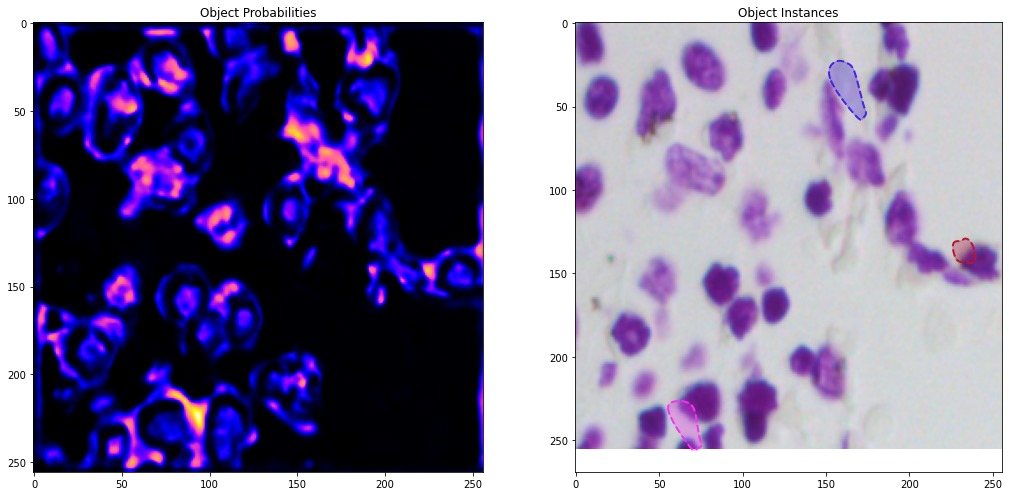

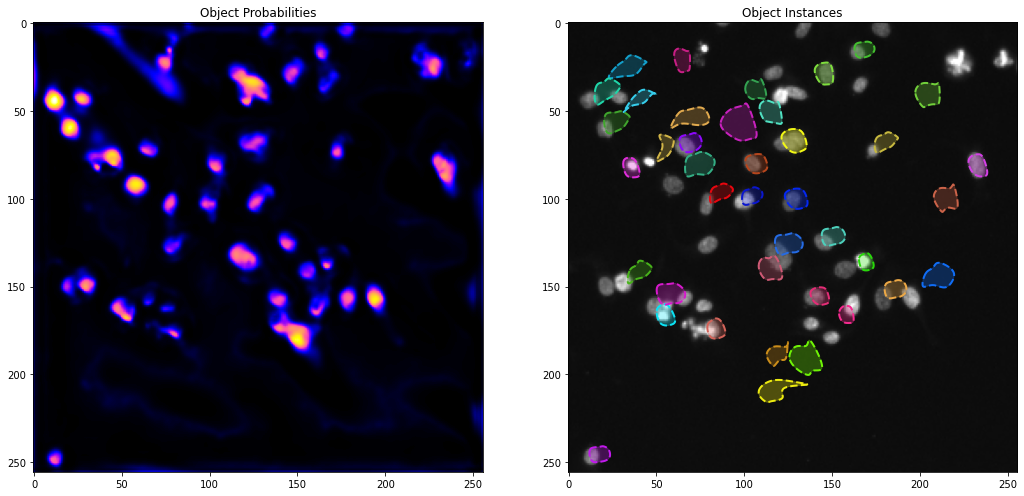

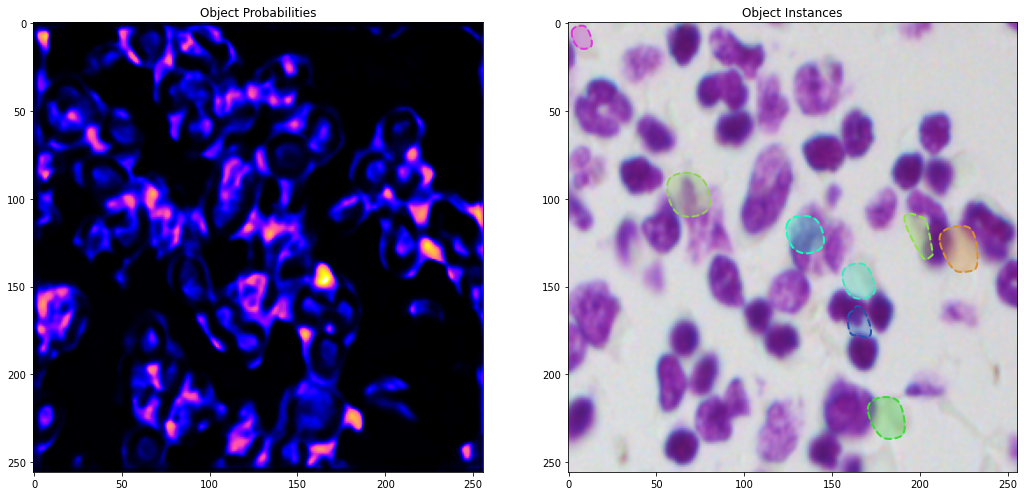

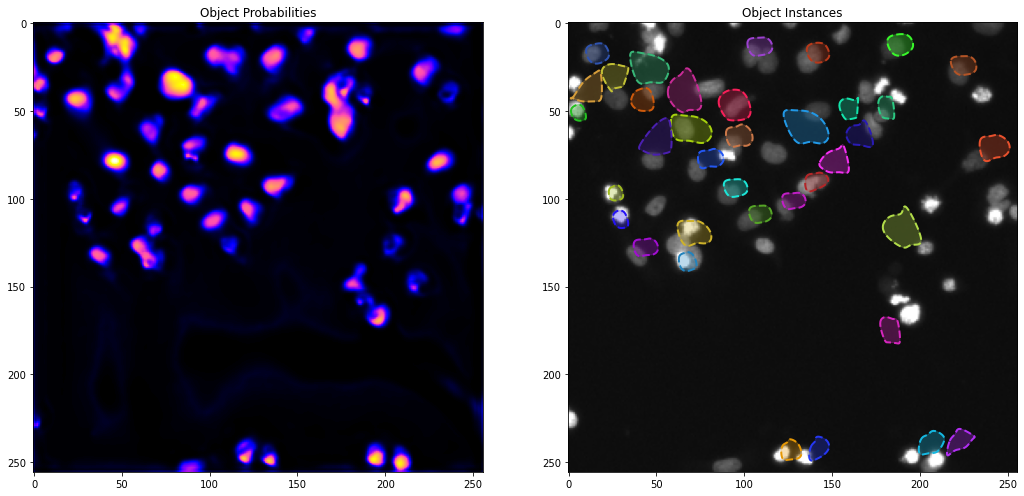

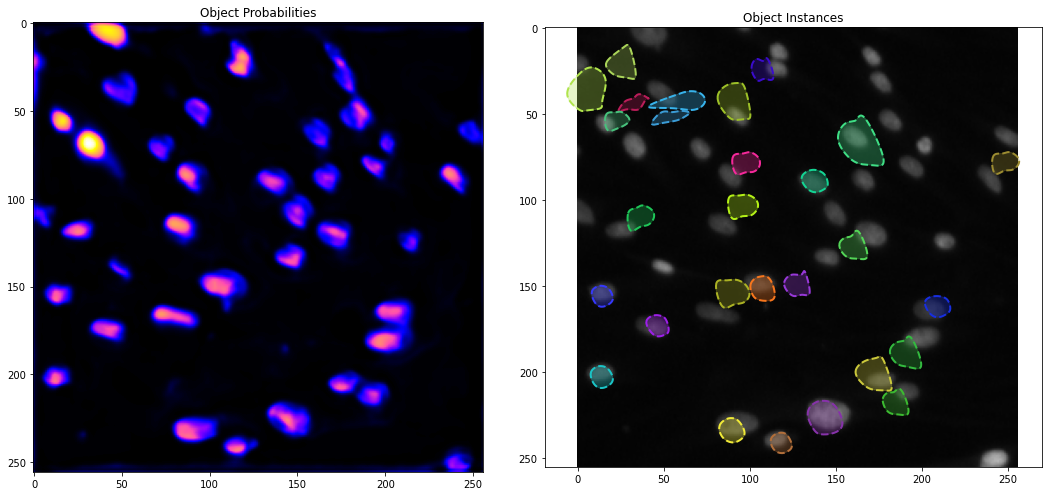

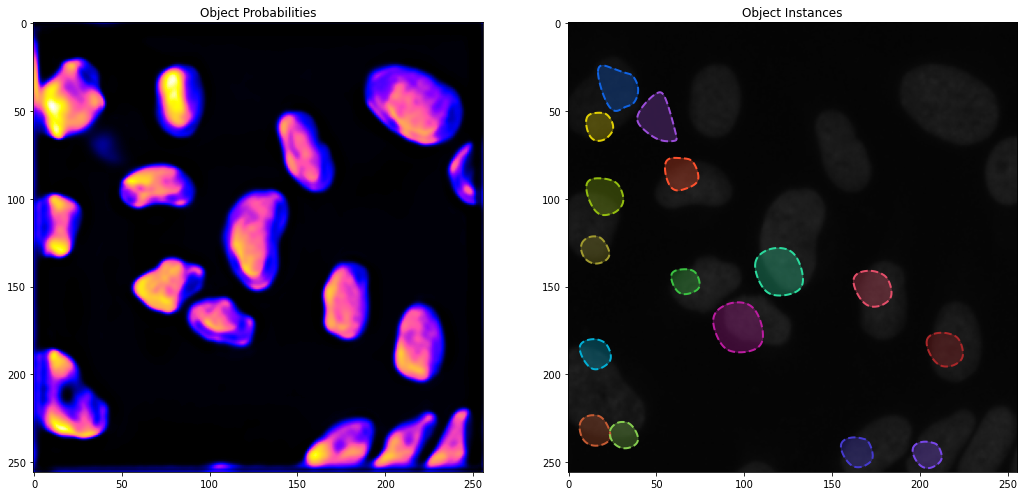

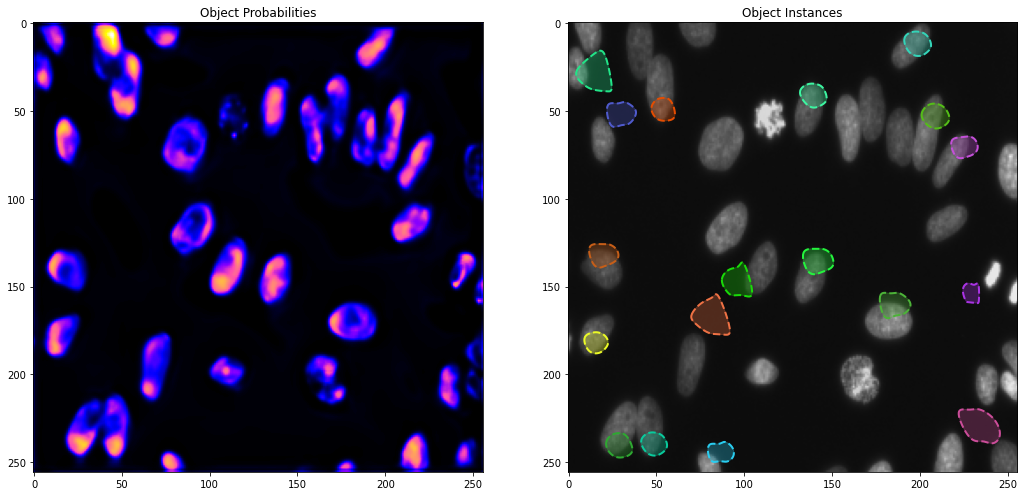

In [22]:
from torchvision.ops import batched_nms

device = "cuda:3"
# torch.cuda.empty_cache()
model = model.to(device)
#model = SplineDist.load_from_checkpoint(checkpoint_path="Models/weights/splineDist-epoch=00-val_loss=3.45-v1.ckpt").to(device)
data = Nuclie_data("../Datasets/DSB18/train")
threshold = 0.5
MAX_CONTOUR_SIZE = 291
MAX_INSTANCES = 1000
np.random.seed(45)
idxs = np.random.randint(0, len(data), 10)
for i, idx in enumerate(idxs):
    
    img, target = data[idx]
    (targetObjectProbas, targetOverlapProbas, targetContours, mask) = target.values()

    img = img.unsqueeze(0).to(device)
    targetObjectProbas = targetObjectProbas.unsqueeze(0).to(device)
    targetOverlapProbas = targetOverlapProbas.unsqueeze(0).to(device)
    targetContours = targetContours.to(device)

    (objectProbas, angles, distances, controlPoints) = model(img)
    objectProbas = torch.sigmoid(objectProbas)
    
    contours = getContourSamples(controlPoints, model.B3M).permute(1, 2, 3, 0, 4)
    contours = contours.reshape(-1, MAX_CONTOUR_SIZE, 2)
    # loss = computeContourLoss(objectProbas, contours, targetObjectProbas, targetContours)
    
    xmin = torch.amin(contours[:, :, 1], dim=-1) 
    xmax = torch.amax(contours[:, :, 1], dim=-1)
    ymin = torch.amin(contours[:, :, 0], dim=-1)
    ymax = torch.amax(contours[:, :, 0], dim=-1)

    bboxes = torch.stack([xmin, ymin, xmax, ymax], -1)

    scores = objectProbas[0].reshape(256*256)

    bboxes = bboxes[scores>threshold]
    scores2 = scores[scores>threshold]

    selectedIds = batched_nms(bboxes, scores2, torch.ones(len(scores2)), iou_threshold=0.01)

    bboxes = bboxes.detach().cpu().numpy()
    selectedIds = selectedIds.detach().cpu().numpy()

    rects = bboxes[selectedIds]


    image = np.ones((256,256,3), np.uint8)*255
    image2 = denormalize(img[0].detach().cpu()).numpy().transpose(1, 2, 0)
    ctrs = contours[scores>threshold][selectedIds].detach().cpu().numpy()

    



    fig, (ax3, ax4) = plt.subplots(
                1, 2, figsize=(15, 7))


    ax3.set_title("Object Probabilities")
    # print(objectProbas.min(), objectProbas.max(), objectProbas.ptp())
    ax3.imshow(objectProbas[0, 0].detach().cpu(), cmap='gnuplot2')
    # plt.subplot(1,4,4)
    ax4.set_title("Object Instances")
    # instances, colors = getInstancesImageFromContours(objectContours)
    #ax4.imshow(denormalize(img[0]).cpu().numpy().transpose(1, 2, 0))
    ax4.imshow(image2)
    # ax4.imshow(instances, alpha=0.3)
    colors = [ list(map(lambda x: x/255, getRandomColor())) for j in range(len(contours))]

    for j, box in enumerate(rects):

        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin),
                                  xmax-xmin,
                                  ymax-ymin,
                                  linewidth=1, color=colors[j], alpha=0.3)

        #ax4.add_patch(rect)

        ax4.fill(ctrs[j][:, 1], ctrs[j][:, 0], color=colors[j], alpha=0.3)
        ax4.plot(ctrs[j][:, 1], ctrs[j][:, 0],color=colors[j], linewidth=2, linestyle='dashed')
    #     ax4.fill(targetContours[0][colId2[i], :, 0], targetContours[0][colId2[i], :, 1], color=colors[i], alpha=0.3)
    fig.tight_layout()
    plt.show()



torch.Size([4677, 4])


83it [00:00, 1909.35it/s]

torch.Size([39, 291, 2])


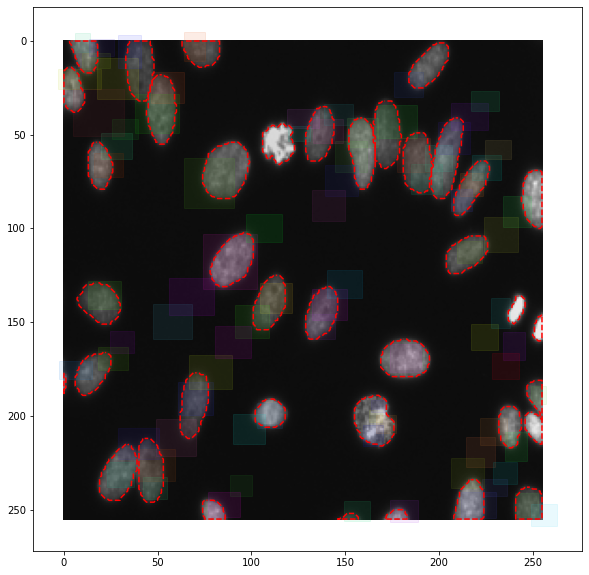

In [12]:
xmin = torch.amin(contours[:, :, 1], dim=-1) 
xmax = torch.amax(contours[:, :, 1], dim=-1)
ymin = torch.amin(contours[:, :, 0], dim=-1)
ymax = torch.amax(contours[:, :, 0], dim=-1)

bboxes = torch.stack([xmin, ymin, xmax, ymax], -1)

scores = targetObjectProbas[0].reshape(256*256)

bboxes = bboxes[scores>0.5]
scores2 = scores[scores>0.5]


selectedIds = batched_nms(bboxes, scores2, torch.ones(len(scores2)), iou_threshold=0.1)
print(bboxes.shape)
bboxes = bboxes.detach().cpu().numpy()
selectedIds = selectedIds.detach().cpu().numpy()

rects = bboxes[selectedIds]


import matplotlib.patches as patches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
# for i, box in tqdm.tqdm(enumerate(rects)):
#     xmin, ymin, xmax, ymax = box
#     rect = patches.Rectangle((xmin, ymin),
#                               xmax-xmin,
#                               ymax-ymin,
#                               linewidth=1, edgecolor="r", facecolor=None, alpha=0.1)

#     # Add the patch to the Axes
#     ax.add_patch(rect)
image = np.ones((256,256,3), np.uint8)*255
image2 = denormalize(img[0].detach().cpu()).numpy().transpose(1, 2, 0)
ax.imshow(image2)
for i, box in tqdm.tqdm(enumerate(rects)):
    
#     xmin, ymin, xmax, ymax = box
    
#     start_point = (xmin, ymin)
#     end_point = (xmax, ymax)

#     image = cv2.rectangle(image,
#                           start_point,
#                           end_point,
#                           (int(colors[i][0]*255),
#                            int(colors[i][1]*255),
#                            int(colors[i][2]*255)), 1)
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin),
                              xmax-xmin,
                              ymax-ymin,
                              linewidth=1, color=colors[i], alpha=0.1)

    # Add the patch to the Axes
    ax.add_patch(rect)
print(targetContours.shape)
ctrs = targetContours.detach().cpu().numpy()
for i, ct in enumerate(ctrs):
    ax.plot(ct[:, 0], ct[:, 1], "r--")
# plt.figure(figsize=(10, 10))
# plt.imshow(image)


7it [00:00, 1193.55it/s]


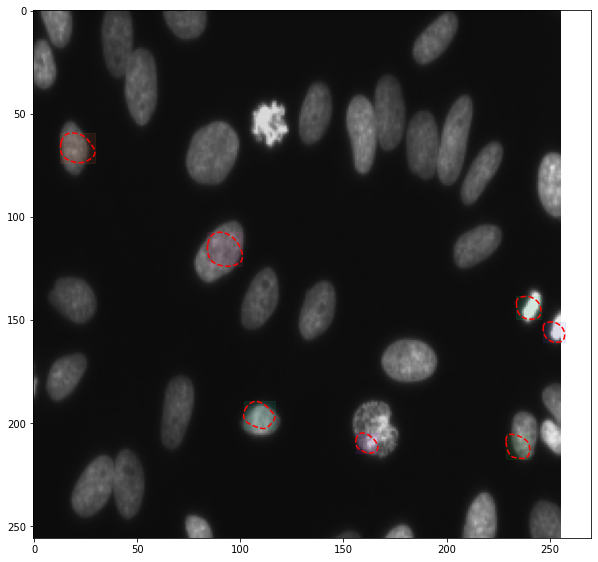

In [95]:
xmin = torch.amin(contours[:, :, 1], dim=-1) 
xmax = torch.amax(contours[:, :, 1], dim=-1)
ymin = torch.amin(contours[:, :, 0], dim=-1)
ymax = torch.amax(contours[:, :, 0], dim=-1)

bboxes = torch.stack([xmin, ymin, xmax, ymax], -1)

scores = objectProbas[0].reshape(256*256)

bboxes = bboxes[scores>0.5]
scores2 = scores[scores>0.5]


selectedIds = batched_nms(bboxes, scores2, torch.ones(len(scores2)), iou_threshold=0.05)

bboxes = bboxes.detach().cpu().numpy()
selectedIds = selectedIds.detach().cpu().numpy()

rects = bboxes[selectedIds]


import matplotlib.patches as patches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

image = np.ones((256,256,3), np.uint8)*255
image2 = denormalize(img[0].detach().cpu()).numpy().transpose(1, 2, 0)
ax.imshow(image2)
for i, box in tqdm.tqdm(enumerate(rects)):
    
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin),
                              xmax-xmin,
                              ymax-ymin,
                              linewidth=1, color=colors[i], alpha=0.1)

    ax.add_patch(rect)

ctrs = contours[scores>0.5][selectedIds].detach().cpu().numpy()
for i, ct in enumerate(ctrs):
    ax.plot(ct[:, 1], ct[:, 0], "r--")
# plt.figure(figsize=(10, 10))
# plt.imshow(image)

In [78]:
contours.shape

torch.Size([65536, 291, 2])

In [10]:

# data = Nuclie_data("src/Datasets/DSB18/train")
# maxes = []
# for i, (img, target) in tqdm.tqdm(enumerate(data)):
#     (targetObjectProbas, targetOverlapProbas, targetContours, mask) = target.values()
#     img = img.unsqueeze(0)
#     maxes.append(max(list(map(len, targetContours))))
contours = np.random.rand(8, 256*256, 291, 2)
contours = torch.from_numpy(contours)
xmin = torch.amin(contours[:, :, :, 1], dim=-1) 
xmax = torch.amax(contours[:, :, :, 1], dim=-1)
ymin = torch.amin(contours[:, :, :, 0], dim=-1)
ymax = torch.amax(contours[:, :, :, 0], dim=-1)

bboxes = torch.stack([xmin, ymin, xmax, ymax], -1)

In [11]:
xmin.shape, bboxes.shape, contours.shape, contours[:, :, :, 1].shape

(torch.Size([8, 65536]),
 torch.Size([8, 65536, 4]),
 torch.Size([8, 65536, 291, 2]),
 torch.Size([8, 65536, 291]))

In [30]:
data = Nuclie_datamodule().train_dataloader()
device = "cuda" if torch.cuda.is_available() else "cpu"

for batch_x, batch_y in tqdm.tqdm(data):
    batch_x = batch_x.to(device)

100%|████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:08<00:00, 16.05it/s]


In [16]:
bboxes[0,1,1] < bboxes[0, 1, 3]

tensor(True)

In [21]:
from scipy.interpolate import splev

In [23]:
ctr = np.vstack((ct[1, 0, :, :], ct[1, 0, :3, :3]))

NameError: name 'ct' is not defined

In [57]:
ctr.shape

(11, 2)

In [58]:
B3M = getBsplineMatrix(291, 3, 11)
pts = B3M @ ctr

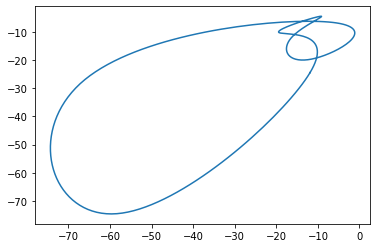

In [59]:
plt.plot(pts[:, 0], pts[:, 1])
# plt.plot(ctr[:, 0], ctr[:, 1], "ro--")

In [36]:
model.B3M

tensor([[0.1667, 0.6667, 0.1667,  ..., 0.0000, 0.0000, 0.0000],
        [0.1582, 0.6664, 0.1754,  ..., 0.0000, 0.0000, 0.0000],
        [0.1500, 0.6655, 0.1845,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1845, 0.6655, 0.1500],
        [0.0000, 0.0000, 0.0000,  ..., 0.1754, 0.6664, 0.1582],
        [0.0000, 0.0000, 0.0000,  ..., 0.1667, 0.6667, 0.1667]],
       device='cuda:0')

In [61]:
controlPoints.shape

torch.Size([1, 256, 256, 8, 2])

In [69]:
controPoints2 = torch.cat((controlPoints, controlPoints[:, :, :, :3, :]), 3)

In [72]:
controPoints2.shape

torch.Size([1, 256, 256, 11, 2])

In [9]:
targetObjectProba, _, _= batch_y

In [12]:
targetObjectProba.max()

tensor(1.)

In [27]:
model.ControlPointsDistanceRegressor.weight.shape

torch.Size([8, 128, 1, 1])

In [30]:
ctrl = torch.stack([distances*torch.cos(angles), distances*torch.sin(angles)], -1)

In [31]:
ctrl.shape

torch.Size([1, 8, 256, 256, 2])

In [35]:
ct = ctrl[0][:, 100, 100, :].detach().cpu().numpy()

array([[ 3.0267148 , -2.0211008 ],
       [-1.4502348 , -3.8906932 ],
       [-3.23534   , -0.09409997],
       [-2.8430314 , -1.0461167 ],
       [-2.2272816 ,  2.6596172 ],
       [ 0.8712981 ,  4.8394074 ],
       [ 3.945827  ,  0.77103764],
       [ 3.5830593 ,  0.92071164]], dtype=float32)

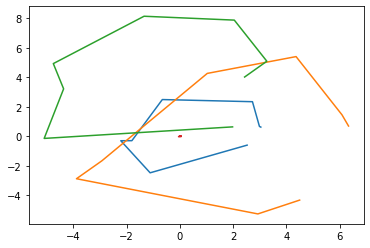

In [47]:
for i in range(0, 256, 128):
    for j in range(0, 256, 128):
        ct = ctrl[0][:, i, j, :].detach().cpu().numpy()
        plt.plot(ct[:, 0], ct[:, 1], "-")